In [1]:
from torch.nn import  Sequential, Conv2d, ReLU, AvgPool2d
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.nn import functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from torch import cuda
from torch import nn
import torchvision
import matplotlib
import torch
import os

In [2]:
devices = torch.device('cuda' if cuda.is_available() else 'cpu')
print(devices)

cuda


In [3]:
size = (64,64)
trans = transforms.Compose(
    [
        transforms.Resize(size=size),
        # transforms.CenterCrop(50),
        # transforms.ColorJitter(brightness=.5,contrast=.4,hue=.6),
        transforms.RandomEqualize(),
        transforms.ToTensor(),
        # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

In [4]:
data_dir = './Data/'
ls = []

# print(os.listdir(data_dir)) #folders in the dataset folder
classes = os.listdir(data_dir + "/Training")
for classses in classes:
    # print(classses)
    ls.append(classses)
# print ('first 10 classes')
print(ls)



['cucumber_1', 'cabbage_white_1', 'apple_golden_3', 'apple_rotten_1', 'apple_red_1', 'apple_hit_1', 'apple_red_3', 'apple_red_yellow_1', 'apple_6', 'apple_braeburn_1', 'cucumber_3', 'zucchini_dark_1', 'carrot_1', 'pear_1', 'apple_red_2', 'eggplant_violet_1', 'pear_3', 'apple_red_delicios_1', 'apple_pink_lady_1', 'apple_golden_2', 'apple_golden_1', 'zucchini_1', 'apple_crimson_snow_1', 'apple_granny_smith_1']


In [5]:
train_ds = ImageFolder(data_dir+"/Training", transform=trans)
val_ds = ImageFolder(data_dir+"/Validation", transform=trans)

In [6]:
img, label = train_ds[0]
print(img.shape, label)
img,train_ds.classes[label]

torch.Size([3, 64, 64]) 0


(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],
 
         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]]]),
 'apple_6')

In [7]:
def show_example(img, label):
    print('Label: ', train_ds.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [8]:
from torch.utils.data.dataloader import DataLoader

batch_size=20

In [9]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [10]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

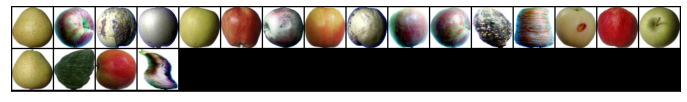

In [11]:
show_batch(train_dl)

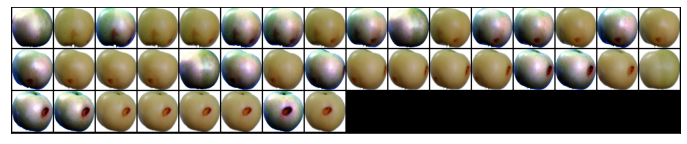

In [12]:
show_batch(val_dl)

In [13]:
for images,_ in train_dl:
    print(images.shape)
    break

torch.Size([20, 3, 64, 64])


In [14]:
class fruitModel(nn.Module):
    def __init__(self, num_classes=155):
        super(fruitModel, self).__init__()
        self.features=nn.Sequential(nn.Conv2d(3,64,kernel_size=11,stride=2,padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=3,stride=2),
                                    
                                   nn.Conv2d(64,192,kernel_size=5,padding=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=3,stride=2),
                                    
                                   nn.Conv2d(192,384,kernel_size=3,padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(384,256,kernel_size=3,padding=1),
                                   nn.ReLU(),
                                   nn.Conv2d(256,256,kernel_size=3,padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=3, stride=2),
                                   )
        self.avgpool = nn.AdaptiveAvgPool2d((6,6))
        self.classifier = nn.Sequential(nn.Dropout(),
                                       nn.Linear(256*6*6,4096),
                                       nn.ReLU(),
                                       nn.Dropout(),
                                       nn.Linear(4096,4096),
                                       nn.ReLU(),
                                       nn.Linear(4096, num_classes))
    def forward(self,x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        x = self.classifier(x)
        return x

In [15]:
cnet = fruitModel()
cnet.to(devices)
optimizer = optim.Adam(cnet.parameters(),lr=0.001)

In [16]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20,device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output, targets)
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output),dim=1)[1],targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        if epoch == 0:
            print(device)
        print('Epoch: {},Training Loss: {:.2f}, Validation Loss: {:.2f}, accuray = {:.2f}'.format(epoch + 1 , training_loss, valid_loss, num_correct / num_examples))

In [17]:
train(cnet,optimizer,torch.nn.CrossEntropyLoss(),train_dl,val_dl,device=devices,epochs=15)

/tmp/ipykernel_24835/3175434463.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  correct = torch.eq(torch.max(F.softmax(output),dim=1)[1],targets).view(-1)


cuda
Epoch: 1,Training Loss: 2.74, Validation Loss: 1.96, accuray = 0.29
Epoch: 2,Training Loss: 1.42, Validation Loss: 0.95, accuray = 0.60
Epoch: 3,Training Loss: 0.81, Validation Loss: 0.57, accuray = 0.76
Epoch: 4,Training Loss: 0.57, Validation Loss: 0.40, accuray = 0.83
Epoch: 5,Training Loss: 0.46, Validation Loss: 0.32, accuray = 0.86
Epoch: 6,Training Loss: 0.36, Validation Loss: 0.22, accuray = 0.91
Epoch: 7,Training Loss: 0.35, Validation Loss: 0.25, accuray = 0.91
Epoch: 8,Training Loss: 0.25, Validation Loss: 0.10, accuray = 0.96
Epoch: 9,Training Loss: 0.33, Validation Loss: 0.14, accuray = 0.96
Epoch: 10,Training Loss: 0.23, Validation Loss: 0.37, accuray = 0.87
Epoch: 11,Training Loss: 0.22, Validation Loss: 0.25, accuray = 0.93
Epoch: 12,Training Loss: 0.22, Validation Loss: 0.17, accuray = 0.95
Epoch: 13,Training Loss: 0.25, Validation Loss: 0.28, accuray = 0.93
Epoch: 14,Training Loss: 0.23, Validation Loss: 0.12, accuray = 0.96
Epoch: 15,Training Loss: 0.15, Validat

In [18]:
devices = torch.device('cpu')

In [19]:
print(devices)

cpu


In [20]:
cnet.to(devices)

fruitModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
   

In [21]:
m = torch.jit.script(cnet)

In [22]:
m

RecursiveScriptModule(
  original_name=fruitModel
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Conv2d)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Dropout)

In [23]:
m.save("scriptmodule.pt")

In [24]:
n = torch.jit.load('scriptmodule.pt')

In [25]:
n

RecursiveScriptModule(
  original_name=fruitModel
  (features): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Conv2d)
    (1): RecursiveScriptModule(original_name=ReLU)
    (2): RecursiveScriptModule(original_name=MaxPool2d)
    (3): RecursiveScriptModule(original_name=Conv2d)
    (4): RecursiveScriptModule(original_name=ReLU)
    (5): RecursiveScriptModule(original_name=MaxPool2d)
    (6): RecursiveScriptModule(original_name=Conv2d)
    (7): RecursiveScriptModule(original_name=ReLU)
    (8): RecursiveScriptModule(original_name=Conv2d)
    (9): RecursiveScriptModule(original_name=ReLU)
    (10): RecursiveScriptModule(original_name=Conv2d)
    (11): RecursiveScriptModule(original_name=ReLU)
    (12): RecursiveScriptModule(original_name=MaxPool2d)
  )
  (avgpool): RecursiveScriptModule(original_name=AdaptiveAvgPool2d)
  (classifier): RecursiveScriptModule(
    original_name=Sequential
    (0): RecursiveScriptModule(original_name=Dropout)

In [26]:
f = open("ls.txt", "a")
for classses in classes:
    # print(classses)
    f.write(classses+ '\n')
f.close()

In [27]:
g = open("ls.txt", "r")
b = g.read()
data_into_list = b.split("\n")
g.close()

In [28]:
data_into_list

['cucumber_1',
 'cabbage_white_1',
 'apple_golden_3',
 'apple_rotten_1',
 'apple_red_1',
 'apple_hit_1',
 'apple_red_3',
 'apple_red_yellow_1',
 'apple_6',
 'apple_braeburn_1',
 'cucumber_3',
 'zucchini_dark_1',
 'carrot_1',
 'pear_1',
 'apple_red_2',
 'eggplant_violet_1',
 'pear_3',
 'apple_red_delicios_1',
 'apple_pink_lady_1',
 'apple_golden_2',
 'apple_golden_1',
 'zucchini_1',
 'apple_crimson_snow_1',
 'apple_granny_smith_1',
 '']